# The Evolution of Stellar Positions

In [71]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
from auriga.images import figure_setup, set_axs_configuration
from auriga.snapshot import Snapshot
from auriga.settings import Settings
from auriga.support import make_snapshot_number
from auriga.parser import parse

In [72]:
figure_setup()

In [21]:
def get_stellar_ids_by_region(simulation: str) -> dict:
    """
    Return a dictionary with all the IDs of the stars in each region in the
    current snapshot.

    Parameters
    ----------
    simulation : str
        The simulation to load.

    Returns
    -------
    ids_by_region : dict
        A dictionary with all the IDs of the stars in each region.
    """

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_star = (s.type == 4) & (s.stellar_formation_time > 0)

    ids_by_region = {}

    settings = Settings()
    for region_tag in settings.component_tags.values():
        is_region = s.region_tag == region_tag
        ids_by_region[region_tag] = s.ids[is_star & is_region]
    
    return ids_by_region

In [75]:
def get_avg_props_of_ids_in_snapshot(simulation: str,
                                     ids_by_region: dict
                                     ) -> tuple:
    """
    Return the average properties of the ids in `ids_by_region` (a dictionary
    of star IDs that populate each region) in the current simulation.

    Paramters
    ---------
    simulation : str
        The simulation to analyze.
    ids_by_region : dict
        A dictionary with the star IDs of the particles in each region of the
        galaxy.
    
    Returns
    -------
    tuple
        A tuple with the time in the first component and a dictionary with
        a list of properties (median spherical radius, median cylindrical
        radius, and median absolute value of z, in that order) for each
        component.
    """

    s = Snapshot(simulation=simulation, loadonlytype=[4])
    s.add_extra_coordinates()

    props_by_region = {}

    for region_tag in ids_by_region:
        idxs = s.get_idxs_of_ids(ids=ids_by_region[region_tag])
        # Remove idxs with values -1 (unmatched particles).
        idxs = idxs[idxs >= 0]

        props_by_region[region_tag] = [np.median(s.r[idxs]),
                                       np.median(s.rho[idxs]),
                                       np.median(np.abs(s.pos[idxs, 2]))]

    return s.time, props_by_region

In [76]:
def get_avg_props_of_present_day_stars(simulation: str) -> pd.DataFrame:
    """
    Create a Pandas DataFrame with the time and the properties of each
    galactic component.

    Parameters
    ----------
    simulation : str
        The simulation to analyze.
    
    Returns
    -------
    pd.DataFrame
        The Pandas DataFrame.
    """
    settings = Settings()

    times = []
    halo_avg_r = []
    halo_avg_rxy = []
    halo_avg_z_abs = []
    bulge_avg_r = []
    bulge_avg_rxy = []
    bulge_avg_z_abs = []
    cold_disc_avg_r = []
    cold_disc_avg_rxy = []
    cold_disc_avg_z_abs = []
    warm_disc_avg_r = []
    warm_disc_avg_rxy = []
    warm_disc_avg_z_abs = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        # Get IDs by region of the last snapshot.
        _, rerun, resolution = parse(simulation)
        n_snapshots = make_snapshot_number(rerun, resolution)
        ids_by_region = get_stellar_ids_by_region(
            f"{simulation}_s{n_snapshots - 1}")

        for i in range(n_snapshots):
            if i >= settings.first_snap:
                time, props_by_region = get_avg_props_of_ids_in_snapshot(
                    simulation=f"{simulation}_s{i}",
                    ids_by_region=ids_by_region)
                
                times.append(time)
                halo_avg_r.append(props_by_region[0][0])
                halo_avg_rxy.append(props_by_region[0][1])
                halo_avg_z_abs.append(props_by_region[0][2])
                bulge_avg_r.append(props_by_region[1][0])
                bulge_avg_rxy.append(props_by_region[1][1])
                bulge_avg_z_abs.append(props_by_region[1][2])
                cold_disc_avg_r.append(props_by_region[2][0])
                cold_disc_avg_rxy.append(props_by_region[2][1])
                cold_disc_avg_z_abs.append(props_by_region[2][2])
                warm_disc_avg_r.append(props_by_region[3][0])
                warm_disc_avg_rxy.append(props_by_region[3][1])
                warm_disc_avg_z_abs.append(props_by_region[3][2])

    # Create data frame.
    df = pd.DataFrame()
    df["Time"] = times
    df["HaloAverageSphericalRadius"] = halo_avg_r
    df["HaloAverageCylindricalRadius"] = halo_avg_rxy
    df["HaloAverageHeightAbs"] = halo_avg_z_abs
    df["BulgeAverageSphericalRadius"] = bulge_avg_r
    df["BulgeAverageCylindricalRadius"] = bulge_avg_rxy
    df["BulgeAverageHeightAbs"] = bulge_avg_z_abs
    df["ColdDiscAverageSphericalRadius"] = cold_disc_avg_r
    df["ColdDiscAverageCylindricalRadius"] = cold_disc_avg_rxy
    df["ColdDiscAverageHeightAbs"] = cold_disc_avg_z_abs
    df["WarmDiscAverageSphericalRadius"] = warm_disc_avg_r
    df["WarmDiscAverageCylindricalRadius"] = warm_disc_avg_rxy
    df["WarmDiscAverageHeightAbs"] = warm_disc_avg_z_abs

    return df

In [80]:
df = get_avg_props_of_present_day_stars("au9_or_l4")

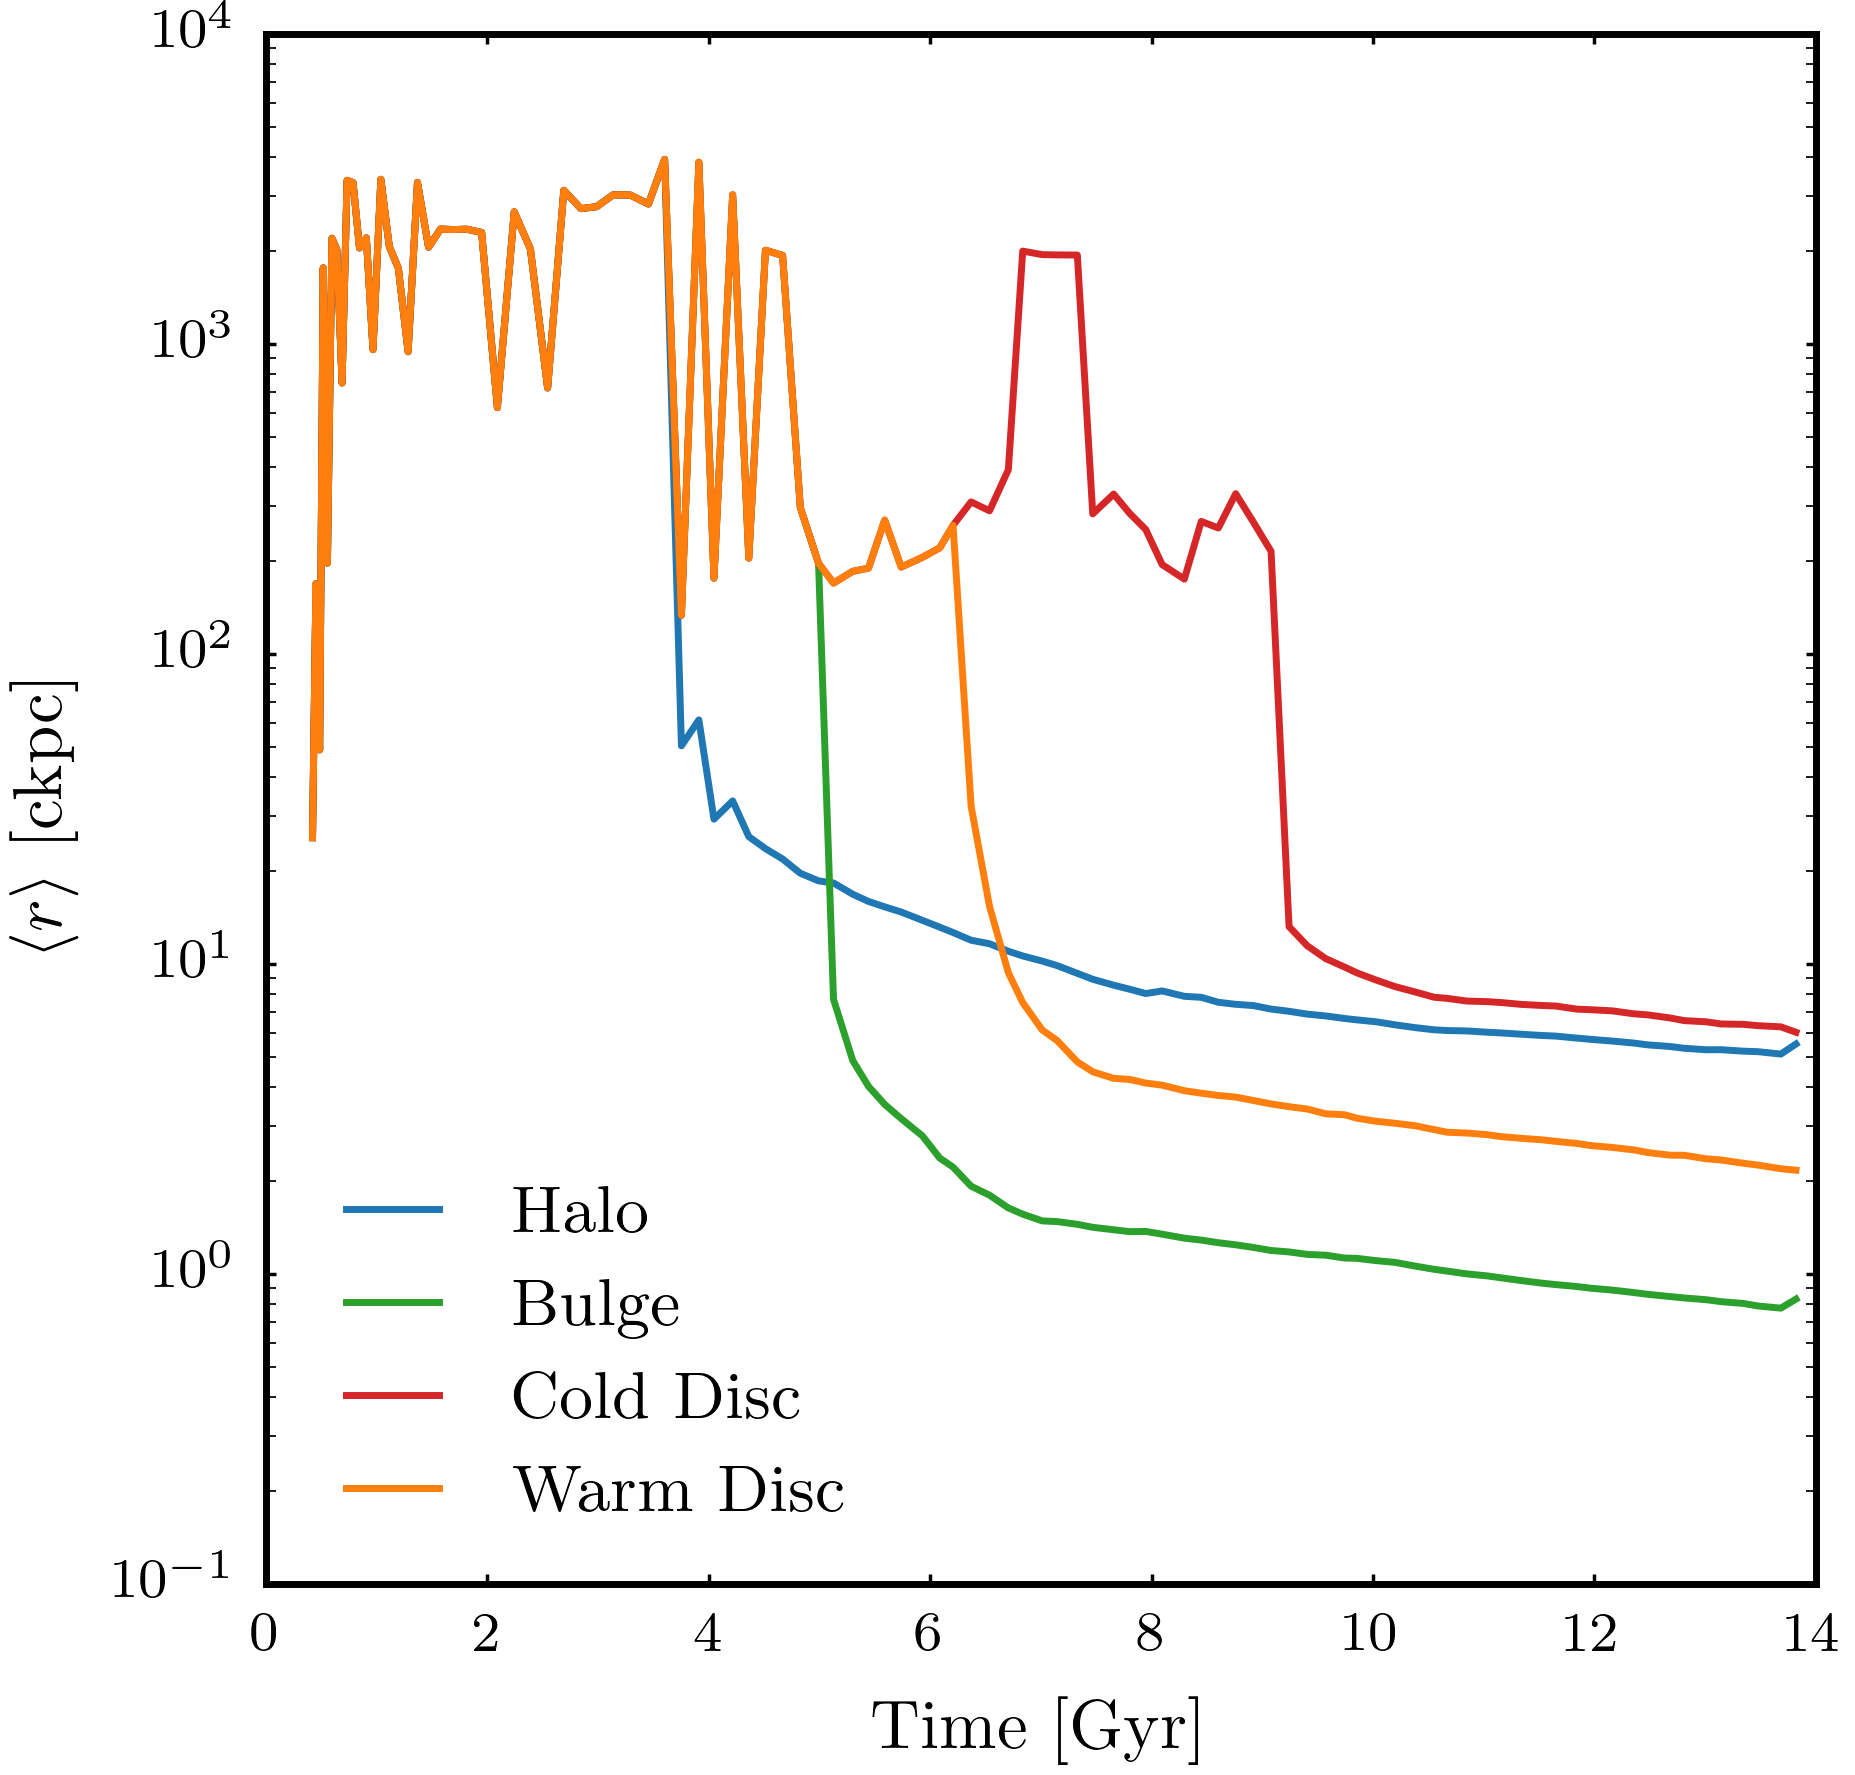

In [93]:
settings = Settings()

fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Time [Gyr]")
ax.set_xlim(0, 14)

ax.set_ylabel(r"$\left< r \right>$ [ckpc]")
# ax.set_ylim(1E3, 2E3)

ax.set_yscale("log")

ax.plot(df["Time"], df["HaloAverageSphericalRadius"],
    color=settings.component_colors['H'],
    label=settings.component_labels["H"])
ax.plot(df["Time"], df["BulgeAverageSphericalRadius"],
    color=settings.component_colors['B'],
    label=settings.component_labels["B"])
ax.plot(df["Time"], df["ColdDiscAverageSphericalRadius"],
    color=settings.component_colors['CD'],
        label=settings.component_labels["CD"])
ax.plot(df["Time"], df["WarmDiscAverageSphericalRadius"],
    color=settings.component_colors['WD'],
        label=settings.component_labels["WD"])

ax.legend(loc="lower left", framealpha=0)

plt.show()

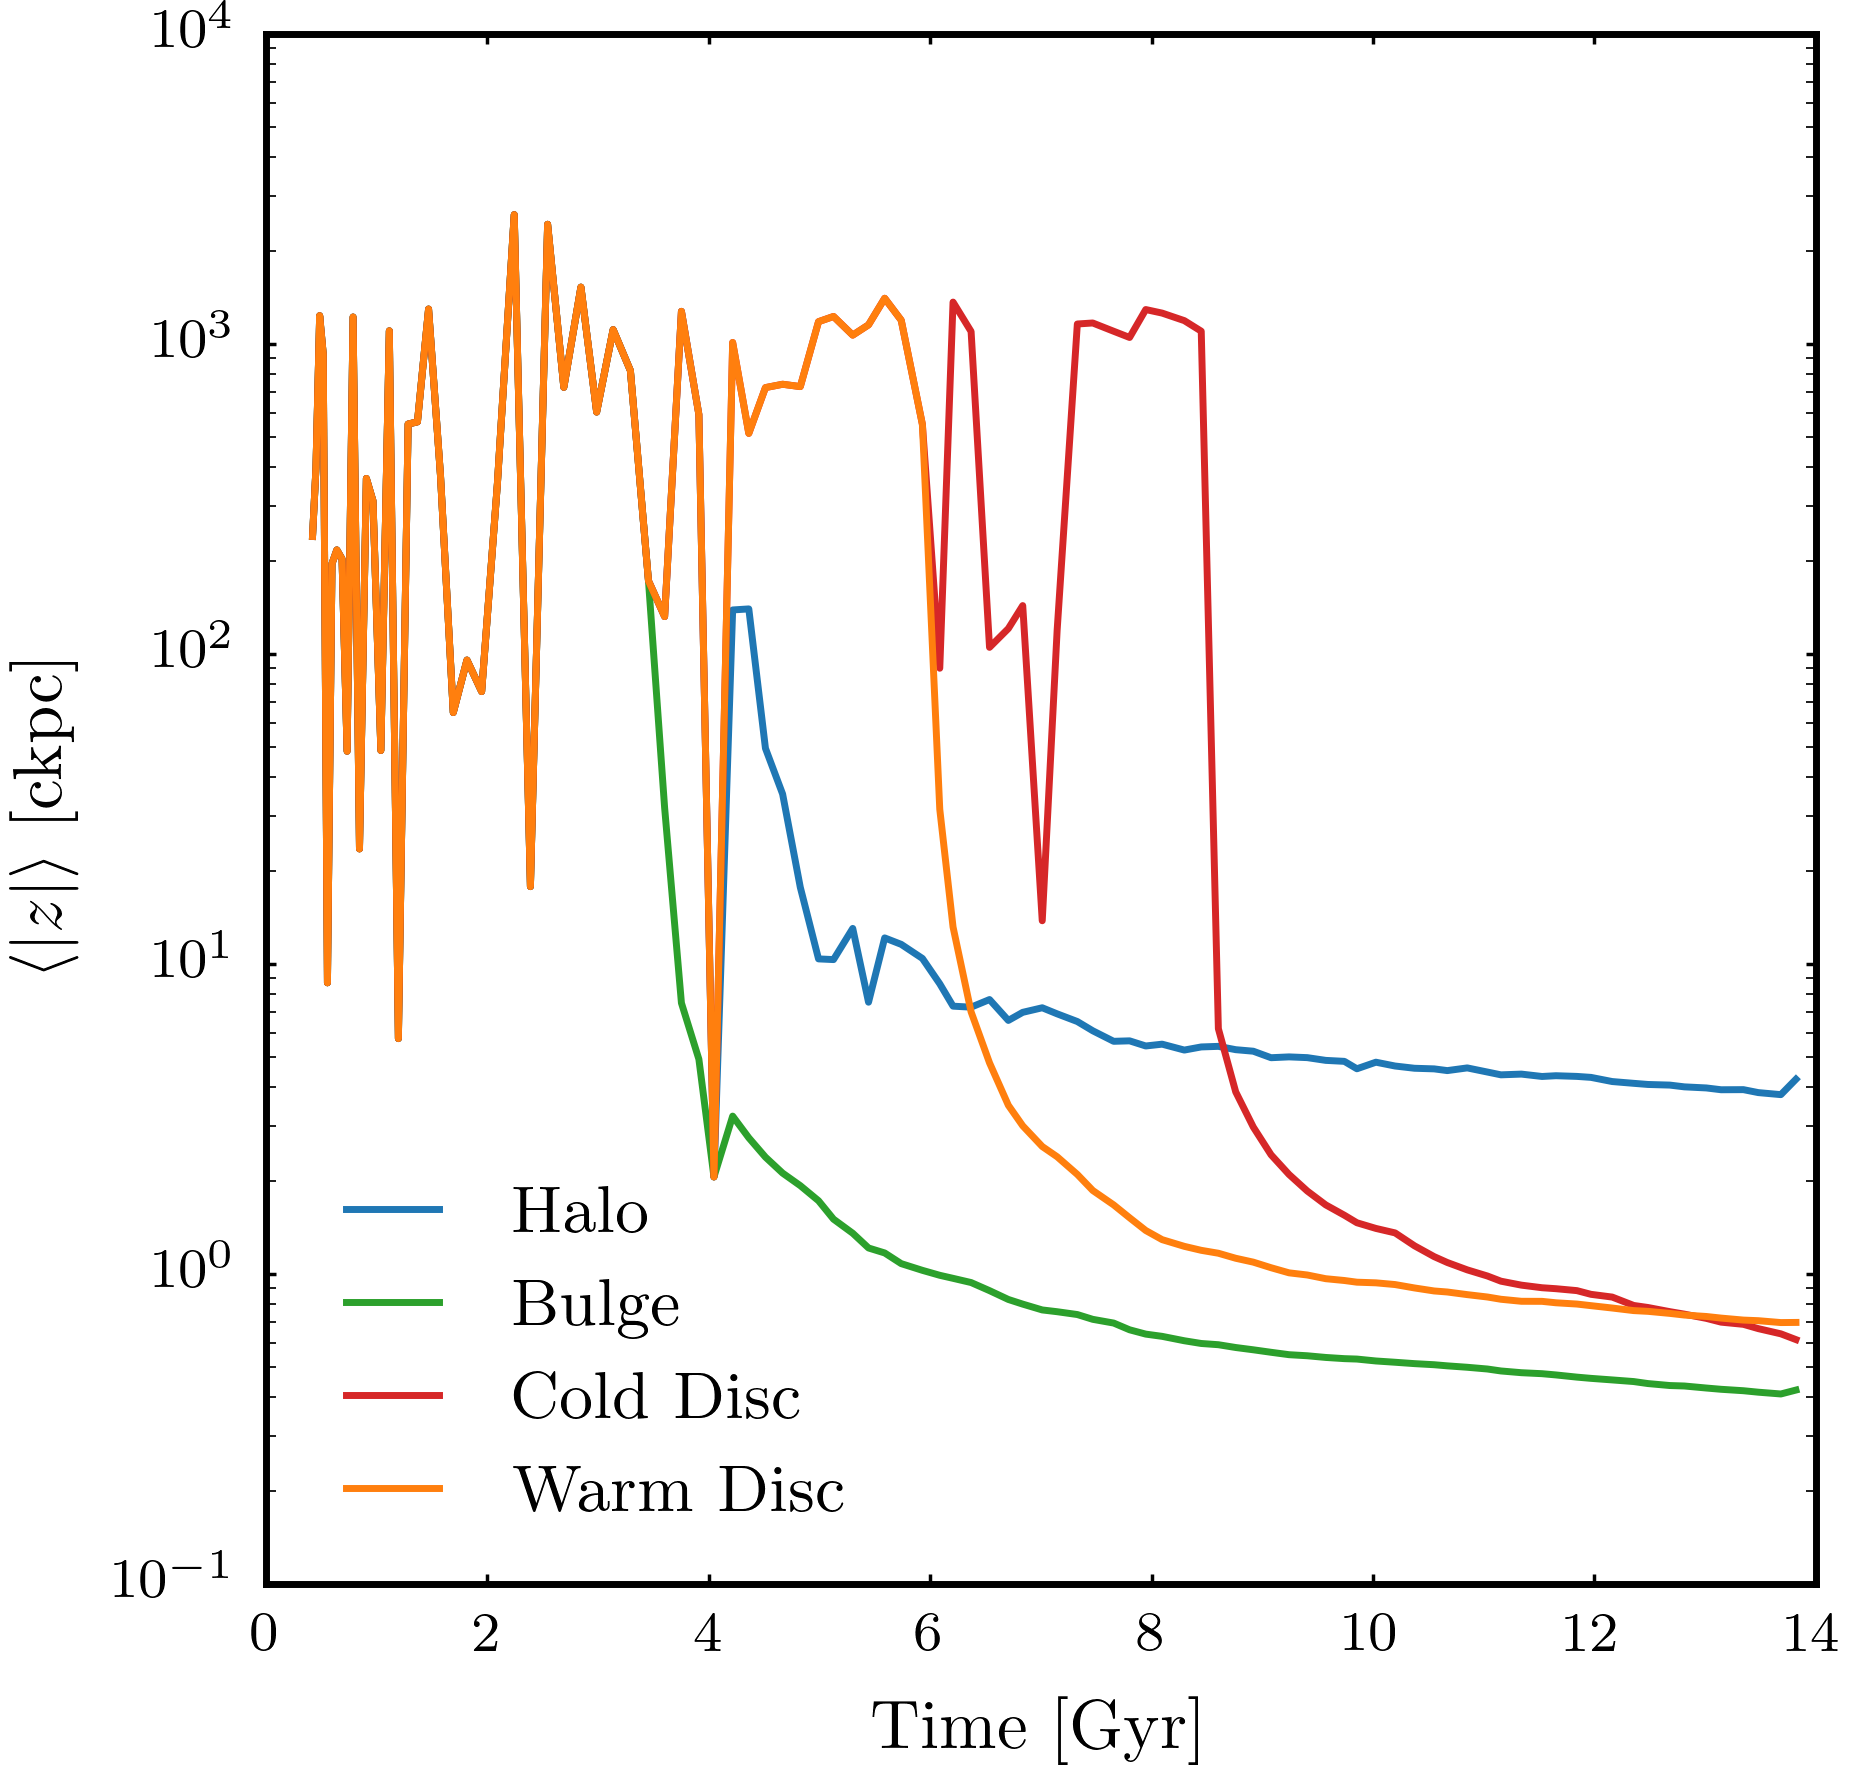

In [79]:
settings = Settings()

fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Time [Gyr]")
ax.set_xlim(0, 14)

ax.set_ylabel(r"$\left< \left| z \right| \right>$ [ckpc]")
# ax.set_ylim(0, 1.6)

ax.set_yscale("log")

ax.plot(df["Time"], df["HaloAverageHeightAbs"],
    color=settings.component_colors['H'],
    label=settings.component_labels["H"])
ax.plot(df["Time"], df["BulgeAverageHeightAbs"],
    color=settings.component_colors['B'],
    label=settings.component_labels["B"])
ax.plot(df["Time"], df["ColdDiscAverageHeightAbs"],
    color=settings.component_colors['CD'],
        label=settings.component_labels["CD"])
ax.plot(df["Time"], df["WarmDiscAverageHeightAbs"],
    color=settings.component_colors['WD'],
        label=settings.component_labels["WD"])

ax.legend(loc="lower left", framealpha=0)

plt.show()